## Part 2: Create a Data Structure that indexes by user & movie

### Version 2.1: Use Tuples and Dict to index data

In [ ]:
import csv
import numpy as np

# Load data
print("Loading ratings...")
ratings = np.loadtxt(
    "ml-32m/ml-32m/ratings.csv",
    delimiter=",",
    skiprows=1,
    usecols=(0, 1, 2)
)

users = ratings[:, 0].astype(int)
movies = ratings[:, 1].astype(int)
scores = ratings[:, 2]

print(f"Loaded {len(ratings):,} ratings")

Loading ratings...
Loaded 32,000,204 ratings


In [ ]:
class SparseMatrix:
  def __init__(self, ratings):
    self.number_of_users = 0
    self.userid_to_idx  = {}
    self.idx_to_userid  = []
    self.data_by_user   = []

    self.number_of_movies = 0
    self.movieid_to_idx = {}
    self.idx_to_movieid = []
    self.data_by_movie  = []

    for rating in ratings:
      if not rating[0] in self.userid_to_idx:
        self.idx_to_userid.append(rating[0])
        self.userid_to_idx[rating[0]] = self.number_of_users
        self.number_of_users += 1
        self.data_by_user.append([])
      if not rating[1] in self.movieid_to_idx:
        self.idx_to_movieid.append(rating[1])
        self.movieid_to_idx[rating[1]] = self.number_of_movies
        self.number_of_movies += 1
        self.data_by_movie.append([])

      self.data_by_user[self.userid_to_idx[rating[0]]].append((self.movieid_to_idx[rating[1]],rating[2].item()))
      self.data_by_movie[self.movieid_to_idx[rating[1]]].append((self.userid_to_idx[rating[0]],rating[2].item()))

  def bin_search(self, array : list, value : int, key = lambda x:x):
    """
    Performs a binary search on a sorted list to find the index of a value.

    Args:
        array (list): The sorted list to search through.
        value (int): The value to search for.

    Returns:
        int: The index of the `value` in the `array`, or -1 if the `value` is not found.
    """
    l = 0
    r = len(array)
    while r > l:
      m = (l+r)//2
      if value == key(array[m]):
        return m
      if value > key(array[m]):
        l = m+1
      else:
        r = m
    return -1

  def get_user_ratings(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie[self.movieid_to_idx[movieid]]
    n_ratings = len(self.data_by_movie[self.movieid_to_idx[movieid]])
    return n_ratings, movie_ratings

  def get_rating(self, userid, movieid):
    if not (userid in self.userid_to_idx and movieid in self.movieid_to_idx):
      return 0
    movie_ratings = self.get_user_ratings(userid)[1]
    idx = self.bin_search(movie_ratings, self.movieid_to_idx[movieid], key = lambda x:x[0])
    return movie_ratings[idx][1]

In [ ]:
ratings_matrix = SparseMatrix(ratings)

In [ ]:
# Query user 1's ratings
n_ratings, user_ratings = ratings_matrix.get_user_ratings(1)
print(f"User 1 rated {n_ratings} movies")
print(user_ratings[:10])

# Query movie 1's ratings
n_ratings, movie_ratings = ratings_matrix.get_movie_ratings(1)
print(f"Movie 1 was rated by {n_ratings} users")
print(movie_ratings[:10])

# Get specific rating
rating = ratings_matrix.get_ratings(1, 17)
print(f"User 1's rating for movie 17: {rating}")

User 1 rated 141 movies
[(0, 4.0), (1, 1.0), (2, 2.0), (3, 5.0), (4, 5.0), (5, 2.0), (6, 1.0), (7, 5.0), (8, 3.0), (9, 5.0)]
Movie 1 was rated by 68997 users
[(9, 2.5), (10, 3.0), (16, 4.0), (18, 3.0), (19, 5.0), (22, 3.0), (23, 4.0), (27, 4.0), (32, 5.0), (33, 4.0)]
User 1's rating for movie 17: 4.0


### Version 2.2: Use Compressed Sparse Row (3 arrays) to index data

In [ ]:
class RatingsCSR:
    """Dual CSR index for MovieLens ratings (by user and by movie)."""

    def __init__(self, ratings_file):
        self.ratings_file = ratings_file

        self.user_data = None
        self.user_indices = None
        self.user_indptr = None
        self.movie_data = None
        self.movie_indices = None
        self.movie_indptr = None
        self.n_users = 0
        self.n_movies = 0

    def load(self):
        """Load ratings into dual CSR format."""
        print("Pass 1: dimensions and count...")
        max_user = max_movie = total_ratings = 0

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                u, m = int(row[0]), int(row[1])
                max_user = max(max_user, u)
                max_movie = max(max_movie, m)
                total_ratings += 1

        self.n_users = max_user
        self.n_movies = max_movie
        print(f"Users: {self.n_users}, Movies: {self.n_movies}, Ratings: {total_ratings}")

        # Initialize arrays
        self.user_data = np.zeros(total_ratings, dtype=np.float32)
        self.user_indices = np.zeros(total_ratings, dtype=np.int32)
        self.user_indptr = np.zeros(self.n_users + 1, dtype=np.int32)
        self.movie_data = np.zeros(total_ratings, dtype=np.float32)
        self.movie_indices = np.zeros(total_ratings, dtype=np.int32)
        self.movie_indptr = np.zeros(self.n_movies + 1, dtype=np.int32)

        print("Pass 2: counting...")
        user_counts = np.zeros(self.n_users, dtype=np.int32)
        movie_counts = np.zeros(self.n_movies, dtype=np.int32)

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                user_counts[int(row[0]) - 1] += 1
                movie_counts[int(row[1]) - 1] += 1

        self.user_indptr[1:] = np.cumsum(user_counts)
        self.movie_indptr[1:] = np.cumsum(movie_counts)

        print("Pass 3: filling arrays and sorting...")
        user_pos = self.user_indptr[:-1].copy()
        movie_pos = self.movie_indptr[:-1].copy()

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                u, m, r = int(row[0]) - 1, int(row[1]) - 1, float(row[2])

                self.user_indices[user_pos[u]] = m
                self.user_data[user_pos[u]] = r
                user_pos[u] += 1

                self.movie_indices[movie_pos[m]] = u
                self.movie_data[movie_pos[m]] = r
                movie_pos[m] += 1

        # Sort both CSRs
        self._sort_csr(self.user_data, self.user_indices, self.user_indptr, self.n_users)
        self._sort_csr(self.movie_data, self.movie_indices, self.movie_indptr, self.n_movies)

        print("Done!")
        return self

    def _sort_csr(self, data, indices, indptr, n):
        """Sort CSR indices for binary search."""
        for i in range(n):
            start, end = indptr[i], indptr[i+1]
            if end - start > 1:
                order = np.argsort(indices[start:end], kind='stable')
                indices[start:end] = indices[start:end][order]
                data[start:end] = data[start:end][order]

    def get_user_ratings(self, user_id):
        """Get all ratings for a user (1-indexed input).

        Returns:
            list of (movie_id, rating) tuples, count
        """
        start, end = self.user_indptr[user_id - 1], self.user_indptr[user_id]
        movie_ids = self.user_indices[start:end] + 1
        ratings = self.user_data[start:end]
        return [(int(m), float(r)) for m, r in zip(movie_ids, ratings)], end - start

    def get_movie_ratings(self, movie_id):
        """Get all ratings for a movie (1-indexed input).

        Returns:
            list of (user_id, rating) tuples, count
        """
        start, end = self.movie_indptr[movie_id - 1], self.movie_indptr[movie_id]
        user_ids = self.movie_indices[start:end] + 1
        ratings = self.movie_data[start:end]
        return [(int(u), float(r)) for u, r in zip(user_ids, ratings)], end - start

    def get_rating(self, user_id, movie_id):
        """Get a specific user-movie rating (1-indexed input).

        Returns:
            float rating or None if not found
        """
        start, end = self.user_indptr[user_id - 1], self.user_indptr[user_id]
        movie_ids = self.user_indices[start:end] + 1
        idx = np.searchsorted(movie_ids, movie_id)
        return float(self.user_data[start + idx]) if idx < len(movie_ids) and movie_ids[idx] == movie_id else None

In [ ]:
ratings_matrix2 = RatingsCSR('ml-32m/ml-32m/ratings.csv')
ratings_matrix2.load()

Pass 1: dimensions and count...
Users: 200948, Movies: 292757, Ratings: 32000204
Pass 2: counting...
Pass 3: filling arrays and sorting...
Done!


In [ ]:
# Query user 1's ratings
user_ratings, count = ratings_matrix2.get_user_ratings(1)
print(f"User 1 rated {count} movies")
print(f"First 5 ratings: {user_ratings[:5]}")

# Query movie 1's ratings
movie_ratings, count = ratings_matrix2.get_movie_ratings(1)
print(f"\nMovie 1 was rated by {count} users")
print(f"First 5 ratings: {movie_ratings[:5]}")

# Get specific rating
rating = ratings_matrix2.get_rating(1, 17)
print(f"\nUser 1's rating for movie 17: {rating}")

User 1 rated 141 movies
First 5 ratings: [(17, 4.0), (25, 1.0), (29, 2.0), (30, 5.0), (32, 5.0)]

Movie 1 was rated by 68997 users
First 5 ratings: [(10, 2.5), (11, 3.0), (17, 4.0), (19, 3.0), (20, 5.0)]

User 1's rating for movie 17: 4.0


### Version 2.3: Use Compressed Sparse Row (2 arrays) to index data

In [ ]:
import csv
import numpy as np

class RatingsCSR:
    """Optimised dual CSR index using 2 arrays per indexing."""

    def __init__(self, ratings_file):
        self.ratings_file = ratings_file

        # User CSR: 2 arrays
        self.user_pairs = None    # [(movie_idx, rating), ...]
        self.user_indptr = None

        # Movie CSR: 2 arrays
        self.movie_pairs = None   # [(user_idx, rating), ...]
        self.movie_indptr = None

        self.n_users = 0
        self.n_movies = 0

    def load(self):
        """Load ratings into dual CSR format."""
        print("Pass 1: dimensions and count...")
        max_user = max_movie = total_ratings = 0

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                u, m = int(row[0]), int(row[1])
                max_user = max(max_user, u)
                max_movie = max(max_movie, m)
                total_ratings += 1

        self.n_users = max_user
        self.n_movies = max_movie
        print(f"Users: {self.n_users}, Movies: {self.n_movies}, Ratings: {total_ratings}")

        # Initialise structured arrays (index & data combined + index pointer)
        # Each element is (index, rating) tuple
        dtype = np.dtype([('idx', np.int32), ('rating', np.float32)])
        self.user_pairs   = np.zeros(total_ratings, dtype=dtype)
        self.user_indptr  = np.zeros(self.n_users + 1, dtype=np.int32)
        self.movie_pairs  = np.zeros(total_ratings, dtype=dtype)
        self.movie_indptr = np.zeros(self.n_movies + 1, dtype=np.int32)

        print("Pass 2: counting users/movies...")
        user_counts  = np.zeros(self.n_users, dtype=np.int32)
        movie_counts = np.zeros(self.n_movies, dtype=np.int32)

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                user_counts[int(row[0]) - 1] += 1
                movie_counts[int(row[1]) - 1] += 1

        self.user_indptr[1:] = np.cumsum(user_counts)
        self.movie_indptr[1:] = np.cumsum(movie_counts)

        print("Pass 3: filling and sorting arrays...")
        user_pos = self.user_indptr[:-1].copy()
        movie_pos = self.movie_indptr[:-1].copy()

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                u, m, r = int(row[0]) - 1, int(row[1]) - 1, float(row[2])

                # Store (movie_idx, rating) tuple for user
                self.user_pairs[user_pos[u]] = (m, r)
                user_pos[u] += 1

                # Store (user_idx, rating) tuple for movie
                self.movie_pairs[movie_pos[m]] = (u, r)
                movie_pos[m] += 1

        # Sort both CSRs by index
        self._sort_csr(self.user_pairs, self.user_indptr, self.n_users)
        self._sort_csr(self.movie_pairs, self.movie_indptr, self.n_movies)

        print("Done!")
        print(f"Memory: User CSR uses 2 arrays, Movie CSR uses 2 arrays (4 total), No dictionary necessary")
        return self

    def _sort_csr(self, pairs, indptr, n):
        """Sort CSR pairs by index for binary search."""
        for i in range(n):
            start, end = indptr[i], indptr[i+1]
            if end - start > 1:
                # Sort by the 'idx' field
                order = np.argsort(pairs[start:end]['idx'], kind='stable')
                pairs[start:end] = pairs[start:end][order]

    def get_user_ratings(self, user_id):
        """Get all ratings for a user (1-indexed input).
        Returns:
            list of (movie_id, rating) tuples, count
        """
        start, end = self.user_indptr[user_id - 1], self.user_indptr[user_id]
        pairs = self.user_pairs[start:end]
        return [(int(p['idx'] + 1), float(p['rating'])) for p in pairs], end - start

    def get_movie_ratings(self, movie_id):
        """Get all ratings for a movie (1-indexed input).
        Returns:
            list of (user_id, rating) tuples, count
        """
        start, end = self.movie_indptr[movie_id - 1], self.movie_indptr[movie_id]
        pairs = self.movie_pairs[start:end]
        return [(int(p['idx'] + 1), float(p['rating'])) for p in pairs], end - start

    def get_rating(self, user_id, movie_id):
        """Get a specific user-movie rating (1-indexed input).
        Returns:
            float rating or None if not found
        """
        start, end = self.user_indptr[user_id - 1], self.user_indptr[user_id]
        pairs = self.user_pairs[start:end]
        indices = pairs['idx']

        # Binary search for movie_id (0-indexed)
        idx = np.searchsorted(indices, movie_id - 1)
        if idx < len(indices) and indices[idx] == movie_id - 1:
            return float(pairs[idx]['rating'])
        return None

In [ ]:
# Load the data
ratings_matrix3 = RatingsCSR2('ml-32m/ml-32m/ratings.csv')
ratings_matrix3.load()

Pass 1: dimensions and count...
Users: 200948, Movies: 292757, Ratings: 32000204
Pass 2: counting...
Pass 3: filling and sorting arrays...
Done!
Memory: User CSR uses 2 arrays, Movie CSR uses 2 arrays (4 total)


### Version 2.4: Use Compressed Sparse Row (2 arrays) with index mapping dict to index data

In [ ]:
import csv
import numpy as np


class RatingsCSR3:
    """Hybrid CSR index: dictionaries for sparse ID mapping + CSR for dense storage."""

    def __init__(self, ratings_file):
        self.ratings_file = ratings_file

        # ID mappings (for sparse IDs)
        self.user_id_to_idx = {}
        self.idx_to_user_id = []
        self.movie_id_to_idx = {}
        self.idx_to_movie_id = []

        # CSR arrays (dense, contiguous storage)
        self.user_pairs = None    # [(movie_idx, rating), ...]
        self.user_indptr = None   # row pointers
        self.movie_pairs = None   # [(user_idx, rating), ...]
        self.movie_indptr = None  # row pointers

        self.n_users = 0
        self.n_movies = 0

    def load(self):
        """Load ratings into hybrid CSR format."""
        print("Pass 1: collect unique IDs and count ratings...")
        user_set = set()
        movie_set = set()
        total_ratings = 0

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                user_set.add(int(row[0]))
                movie_set.add(int(row[1]))
                total_ratings += 1

        # Create mappings (sorted for consistent indexing)
        # NOTE: Internal indices (0, 1, 2, ...) will NOT match original IDs so we'll use the mapping dictionaries to convert between them
        self.idx_to_user_id = sorted(list(user_set))
        self.idx_to_movie_id = sorted(list(movie_set))
        self.user_id_to_idx = {uid: i for i, uid in enumerate(self.idx_to_user_id)}
        self.movie_id_to_idx = {mid: i for i, mid in enumerate(self.idx_to_movie_id)}

        self.n_users = len(self.idx_to_user_id)
        self.n_movies = len(self.idx_to_movie_id)

        print(f"Users: {self.n_users:,}, Movies: {self.n_movies:,}, Ratings: {total_ratings:,}")
        print(f"User ID range: {min(user_set)} - {max(user_set)}")
        print(f"Movie ID range: {min(movie_set)} - {max(movie_set)}")
        print(f"Note: Internal indices are 0-{self.n_users-1} and 0-{self.n_movies-1}")

        # Initialize CSR arrays (dense, contiguous)
        dtype = np.dtype([('idx', np.int32), ('rating', np.float32)])
        self.user_pairs = np.zeros(total_ratings, dtype=dtype)
        self.user_indptr = np.zeros(self.n_users + 1, dtype=np.int32)
        self.movie_pairs = np.zeros(total_ratings, dtype=dtype)
        self.movie_indptr = np.zeros(self.n_movies + 1, dtype=np.int32)

        print("Pass 2: counting...")
        user_counts = np.zeros(self.n_users, dtype=np.int32)
        movie_counts = np.zeros(self.n_movies, dtype=np.int32)

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                u_idx = self.user_id_to_idx[int(row[0])]
                m_idx = self.movie_id_to_idx[int(row[1])]
                user_counts[u_idx] += 1
                movie_counts[m_idx] += 1

        self.user_indptr[1:] = np.cumsum(user_counts)
        self.movie_indptr[1:] = np.cumsum(movie_counts)

        print("Pass 3: filling and sorting...")
        user_pos = self.user_indptr[:-1].copy()
        movie_pos = self.movie_indptr[:-1].copy()

        with open(self.ratings_file, newline='') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                user_id = int(row[0])
                movie_id = int(row[1])
                rating = float(row[2])

                u_idx = self.user_id_to_idx[user_id]
                m_idx = self.movie_id_to_idx[movie_id]

                # Store (movie_idx, rating) pair for user
                self.user_pairs[user_pos[u_idx]] = (m_idx, rating)
                user_pos[u_idx] += 1

                # Store (user_idx, rating) pair for movie
                self.movie_pairs[movie_pos[m_idx]] = (u_idx, rating)
                movie_pos[m_idx] += 1

        # Validate that all positions ended at the expected locations
        assert np.all(user_pos == self.user_indptr[1:]), "User position mismatch after filling"
        assert np.all(movie_pos == self.movie_indptr[1:]), "Movie position mismatch after filling"

        # Sort both CSRs by index for binary search
        self._sort_csr(self.user_pairs, self.user_indptr, self.n_users)
        self._sort_csr(self.movie_pairs, self.movie_indptr, self.n_movies)

        print("Done!")
        return self

    def _sort_csr(self, pairs, indptr, n):
        """Sort CSR pairs by index for binary search."""
        for i in range(n):
            start, end = indptr[i], indptr[i+1]
            if end - start > 1:
                # Get the slice, sort it, and write back to original array
                segment = pairs[start:end].copy()
                order = np.argsort(segment['idx'])
                pairs[start:end] = segment[order]

    def get_user_ratings(self, user_id):
        """Get all ratings for a user (original ID).

        Returns:
            list of (movie_id, rating) tuples, count
        """
        if user_id not in self.user_id_to_idx:
            return [], 0

        u_idx = self.user_id_to_idx[user_id]
        start, end = self.user_indptr[u_idx], self.user_indptr[u_idx + 1]
        pairs = self.user_pairs[start:end]

        # Convert internal movie indices back to original IDs
        return [(self.idx_to_movie_id[p['idx']], float(p['rating'])) for p in pairs], end - start

    def get_movie_ratings(self, movie_id):
        """Get all ratings for a movie (original ID).

        Returns:
            list of (user_id, rating) tuples, count
        """
        if movie_id not in self.movie_id_to_idx:
            return [], 0

        m_idx = self.movie_id_to_idx[movie_id]
        start, end = self.movie_indptr[m_idx], self.movie_indptr[m_idx + 1]
        pairs = self.movie_pairs[start:end]

        # Convert internal user indices back to original IDs
        return [(self.idx_to_user_id[p['idx']], float(p['rating'])) for p in pairs], end - start

    def get_rating(self, user_id, movie_id):
        """Get a specific user-movie rating (original IDs).

        Returns:
            float rating or None if not found
        """
        if user_id not in self.user_id_to_idx or movie_id not in self.movie_id_to_idx:
            return None

        u_idx = self.user_id_to_idx[user_id]
        m_idx = self.movie_id_to_idx[movie_id]

        start, end = self.user_indptr[u_idx], self.user_indptr[u_idx + 1]
        pairs = self.user_pairs[start:end]
        indices = pairs['idx']

        # Binary search for movie index
        # searchsorted returns position in range [0, len(indices)]
        idx = np.searchsorted(indices, m_idx)
        # Check if we found the exact match within bounds
        if idx < (end - start) and indices[idx] == m_idx:
            return float(pairs[idx]['rating'])
        return None

    def memory_usage(self):
        """Report memory usage in MB."""
        # CSR arrays
        user_csr = (self.user_pairs.nbytes + self.user_indptr.nbytes) / 1024**2
        movie_csr = (self.movie_pairs.nbytes + self.movie_indptr.nbytes) / 1024**2

        # Dictionaries (approximate)
        import sys
        user_dict = (sys.getsizeof(self.user_id_to_idx) +
                     sum(sys.getsizeof(k) + sys.getsizeof(v) for k, v in self.user_id_to_idx.items())) / 1024**2
        movie_dict = (sys.getsizeof(self.movie_id_to_idx) +
                      sum(sys.getsizeof(k) + sys.getsizeof(v) for k, v in self.movie_id_to_idx.items())) / 1024**2

        return {
            'user_csr_mb': user_csr,
            'movie_csr_mb': movie_csr,
            'user_dict_mb': user_dict,
            'movie_dict_mb': movie_dict,
            'total_mb': user_csr + movie_csr + user_dict + movie_dict
        }

### Ulrich's Version

In [ ]:
import csv

class RatingsData:
    def __init__(self, file_path):
        self.file_path = file_path

        # Mappings
        self.user_id_to_idx  = {}
        self.idx_to_user_id  = []
        self.movie_id_to_idx = {}
        self.idx_to_movie_id = []

        # Data
        self.data_by_user  = []
        self.data_by_movie = []

    def load(self):
        user_set  = set() # use sets to automaticly avoid duplication
        movie_set = set()

        # First pass: collect all unique IDs
        with open(self.file_path, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            for row in reader:
                user_set.add(int(row[0]))
                movie_set.add(int(row[1]))

        # creating mappings
        self.idx_to_user_id  = sorted(list(user_set))  # convert sets to sorted lists of unique users
        self.idx_to_movie_id = sorted(list(movie_set)) # convert sets to sorted lists of unique movies

        self.user_id_to_idx  = {uid: i for i, uid in enumerate(self.idx_to_user_id)} # create reverse mapping using dict
        self.movie_id_to_idx = {mid: i for i, mid in enumerate(self.idx_to_movie_id)}

        # initialising data lists
        self.n_users  = len(self.idx_to_user_id)
        self.n_movies = len(self.idx_to_movie_id)

        self.data_by_user = [[] for _ in range(self.n_users)]   # number of lists in array equals number of unique users
        self.data_by_movie = [[] for _ in range(self.n_movies)] # number of lists in array equals number of unique movies

        # fill ratings
        with open(self.file_path, 'r') as f:
            reader = csv.reader(f)
            next(reader) # skip header
            for row in reader:
                user_id = int(row[0])
                movie_id = int(row[1])
                rating = float(row[2])

                u_idx = self.user_id_to_idx[user_id] # convert extracted id to index using dict
                m_idx = self.movie_id_to_idx[movie_id]

                self.data_by_user[u_idx].append((m_idx, rating)) # store (index, rating)
                self.data_by_movie[m_idx].append((u_idx, rating)) # store (index, rating)


    def get_user_ratings(self, user_id):
        u_idx = self.user_id_to_idx[user_id]
        return self.data_by_user[u_idx]

    def get_movie_ratings(self, movie_id):
        m_idx = self.movie_id_to_idx[movie_id]
        return self.data_by_movie[m_idx]

    def num_users(self):
        return len(self.idx_to_user_id)

    def num_movies(self):
        return len(self.idx_to_movie_id)

## Part 3.1: Plot rating distributions of data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Compute statistics once
user_ids, user_counts = np.unique(users, return_counts=True)
movie_ids, movie_counts = np.unique(movies, return_counts=True)
unique_ratings, counts = np.unique(scores, return_counts=True)
n_users = len(user_ids)
n_movies = len(movie_ids)
n_ratings = len(ratings)
total_possible = n_users * n_movies
sparsity = 100 * (1 - n_ratings / total_possible)

# 1. Rating Distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(scores, bins=10, kde=True, color='steelblue', ax=ax)
ax.set_title('Rating Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(0.02, 0.98, f'Mean: {scores.mean():.2f}\nMedian: {np.median(scores):.2f}',
        transform=ax.transAxes, verticalalignment='top', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('rating_distribution.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: rating_distribution.svg")

# 2. Rating Value Counts
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette("viridis", len(unique_ratings))
ax.bar(unique_ratings, counts, color=colors, edgecolor='black', linewidth=0.5)
ax.set_title('Count by Rating Value', fontsize=16, fontweight='bold')
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticks(unique_ratings)
for rating, count in zip(unique_ratings, counts):
    ax.text(rating, count, f'{count/1e6:.1f}M', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig('rating_value_counts.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: rating_value_counts.svg")

# 3. User Activity Power Law
fig, ax = plt.subplots(figsize=(10, 6))
user_counts_sorted = np.sort(user_counts)[::-1]
ranks = np.arange(1, len(user_counts_sorted) + 1)
ax.loglog(ranks, user_counts_sorted, color='coral', linewidth=2.5, alpha=0.8)
ax.set_title('User Activity Power Law (Log-Log Scale)\n[Note: Users with <20 ratings excluded from dataset]',
             fontsize=16, fontweight='bold')
ax.set_xlabel('User Rank (log)', fontsize=12)
ax.set_ylabel('Number of Ratings (log)', fontsize=12)
ax.grid(True, alpha=0.3, which='both')
ax.text(0.98, 0.98, f'Median: {np.median(user_counts):.0f}\nMean: {user_counts.mean():.0f}',
        transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('user_activity_powerlaw.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: user_activity_powerlaw.svg")

# 4. Movie Popularity Power Law
fig, ax = plt.subplots(figsize=(10, 6))
movie_counts_sorted = np.sort(movie_counts)[::-1]
ranks = np.arange(1, len(movie_counts_sorted) + 1)
ax.loglog(ranks, movie_counts_sorted, color='mediumseagreen', linewidth=2.5, alpha=0.8)
ax.set_title('Movie Popularity Power Law (Log-Log Scale)', fontsize=16, fontweight='bold')
ax.set_xlabel('Movie Rank (log)', fontsize=12)
ax.set_ylabel('Number of Ratings (log)', fontsize=12)
ax.grid(True, alpha=0.3, which='both')
ax.text(0.98, 0.98, f'Median: {np.median(movie_counts):.0f}\nMean: {movie_counts.mean():.0f}',
        transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('movie_popularity_powerlaw.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: movie_popularity_powerlaw.svg")

# 5. Rating Box Plot
fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot(scores, vert=True, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_edgecolor('navy')
bp['medians'][0].set_color('red')
bp['medians'][0].set_linewidth(2)
ax.set_title('Rating Distribution (Box Plot)', fontsize=16, fontweight='bold')
ax.set_ylabel('Rating', fontsize=12)
ax.set_xticklabels(['All Ratings'], fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('rating_boxplot.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: rating_boxplot.svg")

# 6. Top 20 Most Rated Movies
fig, ax = plt.subplots(figsize=(10, 8))
top_20_idx = np.argsort(movie_counts)[-20:]
top_20_movies = movie_ids[top_20_idx]
top_20_counts = movie_counts[top_20_idx]
y_pos = np.arange(len(top_20_movies))
colors_gradient = sns.color_palette("rocket_r", len(top_20_movies))
ax.barh(y_pos, top_20_counts, color=colors_gradient, edgecolor='black', linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels([f'Movie {m}' for m in top_20_movies], fontsize=10)
ax.set_xlabel('Number of Ratings', fontsize=12)
ax.set_title('Top 20 Most Rated Movies', fontsize=16, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('top_20_movies.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: top_20_movies.svg")

# 7. Top 20 Most Active Users
fig, ax = plt.subplots(figsize=(10, 8))
top_20_users_idx = np.argsort(user_counts)[-20:]
top_20_users = user_ids[top_20_users_idx]
top_20_user_counts = user_counts[top_20_users_idx]
y_pos = np.arange(len(top_20_users))
colors_gradient = sns.color_palette("mako_r", len(top_20_users))
ax.barh(y_pos, top_20_user_counts, color=colors_gradient, edgecolor='black', linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels([f'User {u}' for u in top_20_users], fontsize=10)
ax.set_xlabel('Number of Ratings', fontsize=12)
ax.set_title('Top 20 Most Active Users', fontsize=16, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('top_20_users.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: top_20_users.svg")

# 8. Matrix Sparsity
fig, ax = plt.subplots(figsize=(8, 8))
categories = ['Filled', 'Empty']
values = [n_ratings / total_possible * 100, sparsity]
colors_pie = ['#ff9999', '#66b3ff']
wedges, texts, autotexts = ax.pie(values, labels=categories, autopct='%1.4f%%',
                                    colors=colors_pie, startangle=90,
                                    textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_fontweight('bold')
ax.set_title(f'Matrix Sparsity\n({n_users:,} users × {n_movies:,} movies)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('matrix_sparsity.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: matrix_sparsity.svg")

# 9. Summary Statistics Table
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
stats_data = [
    ['Total Ratings', f'{len(ratings):,}'],
    ['Unique Users', f'{n_users:,}'],
    ['Unique Movies', f'{n_movies:,}'],
    ['Avg Ratings/User', f'{user_counts.mean():.1f}'],
    ['Avg Ratings/Movie', f'{movie_counts.mean():.1f}'],
    ['Rating Mean', f'{scores.mean():.3f}'],
    ['Rating Std', f'{scores.std():.3f}'],
    ['Rating Median', f'{np.median(scores):.1f}'],
    ['Sparsity', f'{sparsity:.4f}%'],
]

table = ax.table(cellText=stats_data, cellLoc='left',
                 colWidths=[0.5, 0.5], loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2.5)

for i in range(len(stats_data)):
    table[(i, 0)].set_facecolor('#e6f2ff')
    table[(i, 0)].set_text_props(weight='bold')
    table[(i, 1)].set_facecolor('#f0f0f0')

ax.set_title('Dataset Statistics', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('dataset_statistics.svg', format='svg', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: dataset_statistics.svg")

# Print summary
print("\n" + "="*60)
print("ALL PLOTS SAVED AS HIGH-QUALITY SVG FILES")
print("="*60)
print("\nFiles created:")
print("  1. rating_distribution.svg")
print("  2. rating_value_counts.svg")
print("  3. user_activity_powerlaw.svg")
print("  4. movie_popularity_powerlaw.svg")
print("  5. rating_boxplot.svg")
print("  6. top_20_movies.svg")
print("  7. top_20_users.svg")
print("  8. matrix_sparsity.svg")
print("  9. dataset_statistics.svg")
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total ratings: {len(ratings):,}")
print(f"Unique users: {n_users:,}")
print(f"Unique movies: {n_movies:,}")
print(f"Rating range: {scores.min():.1f} - {scores.max():.1f}")
print(f"Average rating: {scores.mean():.3f} ± {scores.std():.3f}")
print(f"Median rating: {np.median(scores):.1f}")
print(f"Sparsity: {sparsity:.4f}%")
print(f"Most common rating: {unique_ratings[np.argmax(counts)]:.1f} ({counts.max():,} times)")

✓ Saved: rating_distribution.svg
✓ Saved: rating_value_counts.svg
✓ Saved: user_activity_powerlaw.svg
✓ Saved: movie_popularity_powerlaw.svg
✓ Saved: rating_boxplot.svg
✓ Saved: top_20_movies.svg
✓ Saved: top_20_users.svg
✓ Saved: matrix_sparsity.svg
✓ Saved: dataset_statistics.svg

ALL PLOTS SAVED AS HIGH-QUALITY SVG FILES

Files created:
  1. rating_distribution.svg
  2. rating_value_counts.svg
  3. user_activity_powerlaw.svg
  4. movie_popularity_powerlaw.svg
  5. rating_boxplot.svg
  6. top_20_movies.svg
  7. top_20_users.svg
  8. matrix_sparsity.svg
  9. dataset_statistics.svg

DATASET SUMMARY
Total ratings: 32,000,204
Unique users: 200,948
Unique movies: 84,432
Rating range: 0.5 - 5.0
Average rating: 3.540 ± 1.059
Median rating: 3.5
Sparsity: 99.8114%
Most common rating: 4.0 (8,367,654 times)


## Part 3.2: Power Law Distribution

✓ Saved: powerlaw_combined_stunning.svg


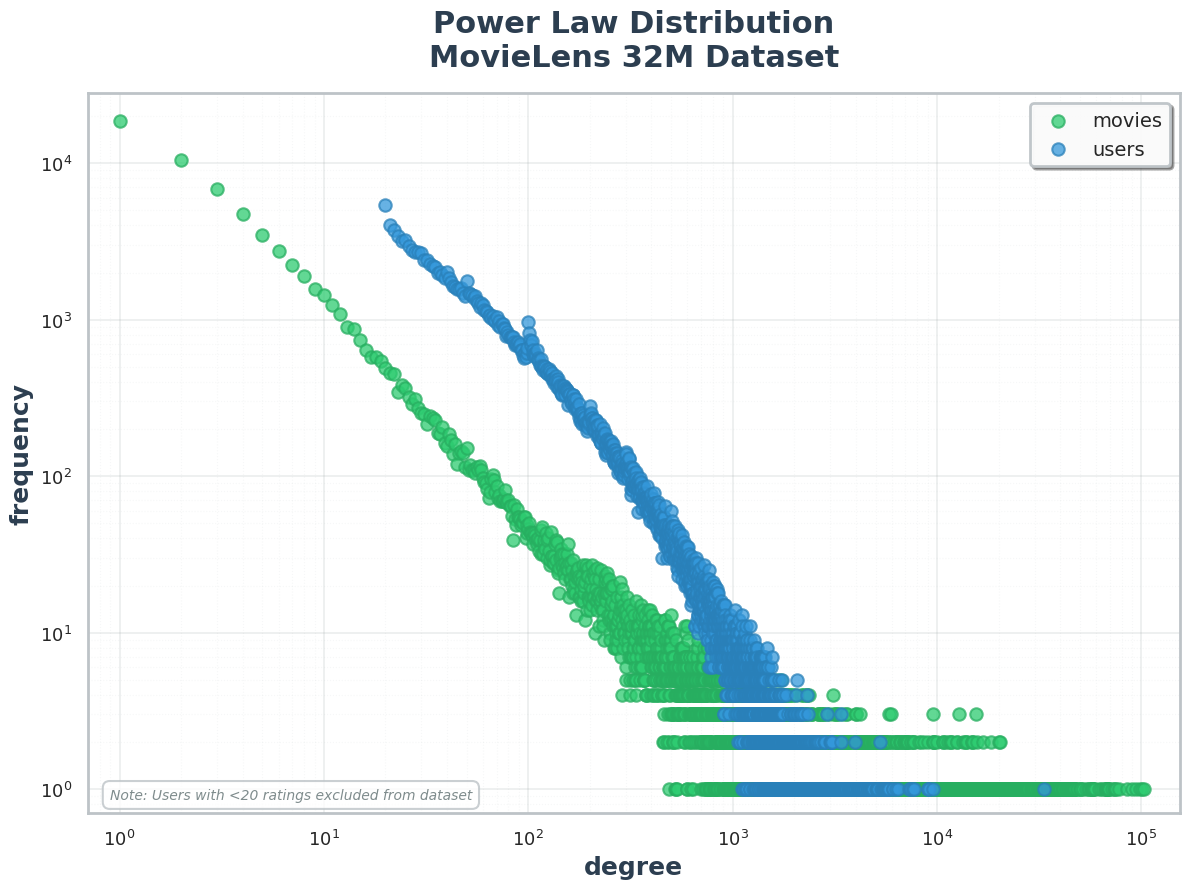

In [ ]:
# Compute degree distributions
user_ids, user_counts = np.unique(users, return_counts=True)
movie_ids, movie_counts = np.unique(movies, return_counts=True)

user_degree_vals, user_degree_freq = np.unique(user_counts, return_counts=True)
movie_degree_vals, movie_degree_freq = np.unique(movie_counts, return_counts=True)

# Create stunning visualization
fig, ax = plt.subplots(figsize=(12, 9), facecolor='white')

# Plot items FIRST (green, background layer)
ax.scatter(movie_degree_vals, movie_degree_freq,
           c='#2ecc71', marker='o', s=80,
           alpha=0.75, label='movies',
           edgecolors='#27ae60', linewidth=1.5,
           zorder=2)

# Plot users SECOND (blue, foreground layer) - will overlay items
ax.scatter(user_degree_vals, user_degree_freq,
           c='#3498db', marker='o', s=80,
           alpha=0.75, label='users',
           edgecolors='#2980b9', linewidth=1.5,
           zorder=3)

# Logarithmic scales
ax.set_xscale('log')
ax.set_yscale('log')

# Styling
ax.set_xlabel('degree', fontsize=18, fontweight='bold', color='#2c3e50')
ax.set_ylabel('frequency', fontsize=18, fontweight='bold', color='#2c3e50')
ax.set_title('Power Law Distribution\nMovieLens 32M Dataset',
             fontsize=22, fontweight='bold', color='#2c3e50', pad=20)

# Legend with elegant styling
legend = ax.legend(fontsize=14, loc='upper right', frameon=True,
                   shadow=True, fancybox=True, framealpha=0.95)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('#bdc3c7')
legend.get_frame().set_linewidth(2)

# Grid with subtle styling
ax.grid(True, alpha=0.15, which='both', linestyle='-', linewidth=1.2, color='#7f8c8d')
ax.grid(True, alpha=0.08, which='minor', linestyle=':', linewidth=0.8, color='#95a5a6')

# Axis limits for optimal view
ax.set_xlim(0.7, max(max(user_degree_vals), max(movie_degree_vals)) * 1.5)
ax.set_ylim(0.7, max(max(user_degree_freq), max(movie_degree_freq)) * 1.5)

# Enhanced tick styling
ax.tick_params(axis='both', which='major', labelsize=13,
               width=1.5, length=8, color='#34495e')
ax.tick_params(axis='both', which='minor',
               width=1, length=4, color='#7f8c8d')

# Spine styling
for spine in ax.spines.values():
    spine.set_edgecolor('#bdc3c7')
    spine.set_linewidth(2)

# Add subtle annotation about truncation
ax.text(0.02, 0.02,
        'Note: Users with <20 ratings excluded from dataset',
        transform=ax.transAxes,
        fontsize=10, style='italic', color='#7f8c8d',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                  edgecolor='#bdc3c7', alpha=0.8, linewidth=1.5))

plt.tight_layout()
plt.savefig('powerlaw_combined_stunning.svg', format='svg', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: powerlaw_combined_stunning.svg")
plt.show()

## Part 4: Train Test Split

### Load MovieLens 100k dataset

In [ ]:
from google.colab import drive

# Mount your Drive
drive.mount('/content/drive')

# File path
data_path = "/content/drive/MyDrive/Data/ML at Scale/ml-latest-small/" # MovieLens 100k dataset
data_file = "ratings.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Data/ML at Scale/ml-latest-small/"

/content/drive/MyDrive/Data/ML at Scale/ml-latest-small


### Ulrich's Version

In [ ]:
data100k = RatingsData(data_file)
data100k.load()

In [ ]:
import numpy as np

n_users = len(data100k.data_by_user)
n_movies = len(data100k.data_by_movie)

# initialising data lists (same # of lists for test/train for consistent indexing)
data_by_user_train = [[] for _ in range(n_users)]
data_by_user_test  = [[] for _ in range(n_users)]
data_by_movie_train = [[] for _ in range(n_movies)]
data_by_movie_test  = [[] for _ in range(n_movies)]

np.random.seed(42)

# data_by_user split
for i in range(n_users): # loop over all users
    tuples = data100k.data_by_user[i]

    # Ensure at least one rating goes to train
    if len(tuples) > 0:
        data_by_user_train[i].append(tuples[0])  # First rating always to train

        for movie_idx, rating in tuples[1:]: # loop over remaining tuples
            if np.random.rand() < 0.9:
                data_by_user_train[i].append((movie_idx, rating)) # add to train
            else:
                data_by_user_test[i].append((movie_idx, rating)) # add to test

# data_by_movie split
for user_idx in range(n_users): # loop over all users
    # train
    for movie_idx, rating in data_by_user_train[user_idx]: # loop over all tuples
        data_by_movie_train[movie_idx].append((user_idx, rating)) # add in correct movie_idx and replace (movie_idx with user_idx in tuple)

    # test
    for movie_idx, rating in data_by_user_test[user_idx]:
        data_by_movie_test[movie_idx].append((user_idx, rating))

In [ ]:
non_empty_users_train = sum(1 for u in data_by_user_train if len(u) > 0)
non_empty_users_test = sum(1 for u in data_by_user_test if len(u) > 0)

print(f"number of items in users train and test sets: {len(data_by_user_train)} , {len(data_by_user_test)}")
print(f"Number of users with ratings in train and test sets: {non_empty_users_train}, {non_empty_users_test}")

print()

non_empty_movies_train = sum(1 for u in data_by_movie_train if len(u) > 0)
non_empty_movies_test = sum(1 for u in data_by_movie_test if len(u) > 0)

print(f"number of items in movies train and test sets: {len(data_by_movie_train)}, {len(data_by_movie_test)}")
print(f"Number of movies with ratings in train and test sets: {non_empty_movies_train}, {non_empty_movies_test}")

number of items in users train and test sets: 610 , 610
Number of users with ratings in train and test sets: 610, 601

number of items in movies train and test sets: 9724, 9724
Number of movies with ratings in train and test sets: 9356, 3623


### Version 2.4

In [ ]:
df2 = RatingsCSR3(data_file)
df2.load()

Pass 1: collect unique IDs and count ratings...
Users: 610, Movies: 9,724, Ratings: 100,836
User ID range: 1 - 610
Movie ID range: 1 - 193609
Note: Internal indices are 0-609 and 0-9723
Pass 2: counting...
Pass 3: filling and sorting...
Done!


In [ ]:
# Query user 1's ratings
user_ratings, count = df2.get_user_ratings(1)
print(f"User 1 rated {count} movies")
print(f"First 5 ratings: {user_ratings[:5]}")

# Query movie 1's ratings
movie_ratings, count = df2.get_movie_ratings(1)
print(f"\nMovie 1 was rated by {count} users")
print(f"First 5 ratings: {movie_ratings[:5]}")

# Get specific rating
rating = df2.get_rating(1, 17)
print(f"\nUser 1's rating for movie 17: {rating}")

User 1 rated 232 movies
First 5 ratings: [(1, 4.0), (3, 4.0), (6, 4.0), (47, 5.0), (50, 5.0)]

Movie 1 was rated by 215 users
First 5 ratings: [(1, 4.0), (5, 4.0), (7, 4.5), (15, 2.5), (17, 4.5)]

User 1's rating for movie 17: None


In [ ]:
n_users  = df2.n_users
n_movies = df2.n_movies

user_pairs_train = [[] for _ in range(n_users)]
user_pairs_test  = [[] for _ in range(n_users)]
movie_pairs_train = [[] for _ in range(n_movies)]
movie_pairs_test  = [[] for _ in range(n_movies)]

# user split
for i in range(n_users):
    start, end = df2.user_indptr[i], df2.user_indptr[i+1]
    ratings = df2.user_pairs[start:end]

    for pair in ratings:
        movie_idx = pair['idx']
        rating = pair['rating']

        if np.random.rand() < 0.9:
            user_pairs_train[i].append((movie_idx, rating))
        else:
            user_pairs_test[i].append((movie_idx, rating))

# corresponding movie split
for user_idx in range(n_users):

    # train
    for movie_idx, rating in user_pairs_train[user_idx]:
        movie_pairs_train[movie_idx].append((user_idx, rating))

    # test
    for movie_idx, rating in user_pairs_test[user_idx]:
        movie_pairs_test[movie_idx].append((user_idx, rating))

In [ ]:
non_empty_users_train = sum(1 for u in user_pairs_train if len(u) > 0)
non_empty_users_test = sum(1 for u in user_pairs_test if len(u) > 0)

print(f"number of users in users train and test sets: {len(user_pairs_train)} , {len(user_pairs_test)}")
print(f"Number of users with ratings in train and test sets: {non_empty_users_train}, {non_empty_users_test}")

print()

non_empty_movies_train = sum(1 for m in movie_pairs_train if len(m) > 0)
non_empty_movies_test = sum(1 for m in movie_pairs_test if len(m) > 0)

print(f"number of items in movies train and test sets: {len(movie_pairs_train)}, {len(movie_pairs_test)}")
print(f"Number of movies with ratings in train and test sets: {non_empty_movies_train}, {non_empty_movies_test}")

number of users in users train and test sets: 610 , 610
Number of users with ratings in train and test sets: 610, 595

number of items in movies train and test sets: 9724, 9724
Number of movies with ratings in train and test sets: 9357, 3723


## Part 5: Bias Optimisation

### Ulrich's Version

Iteration 1/50: Train RMSE = 0.8086, Test RMSE = 3.5887, Loss = 59489.79
Iteration 2/50: Train RMSE = 0.7938, Test RMSE = 3.5866, Loss = 57331.76
Iteration 3/50: Train RMSE = 0.7926, Test RMSE = 3.5875, Loss = 57156.44
Iteration 4/50: Train RMSE = 0.7924, Test RMSE = 3.5886, Loss = 57126.79
Iteration 5/50: Train RMSE = 0.7923, Test RMSE = 3.5895, Loss = 57117.14
Iteration 6/50: Train RMSE = 0.7923, Test RMSE = 3.5904, Loss = 57111.84
Iteration 7/50: Train RMSE = 0.7923, Test RMSE = 3.5912, Loss = 57107.93
Iteration 8/50: Train RMSE = 0.7922, Test RMSE = 3.5919, Loss = 57104.72
Iteration 9/50: Train RMSE = 0.7922, Test RMSE = 3.5926, Loss = 57101.98
Iteration 10/50: Train RMSE = 0.7922, Test RMSE = 3.5932, Loss = 57099.61
Iteration 11/50: Train RMSE = 0.7922, Test RMSE = 3.5938, Loss = 57097.56
Iteration 12/50: Train RMSE = 0.7922, Test RMSE = 3.5944, Loss = 57095.77
Iteration 13/50: Train RMSE = 0.7922, Test RMSE = 3.5949, Loss = 57094.21
Iteration 14/50: Train RMSE = 0.7922, Test RMSE

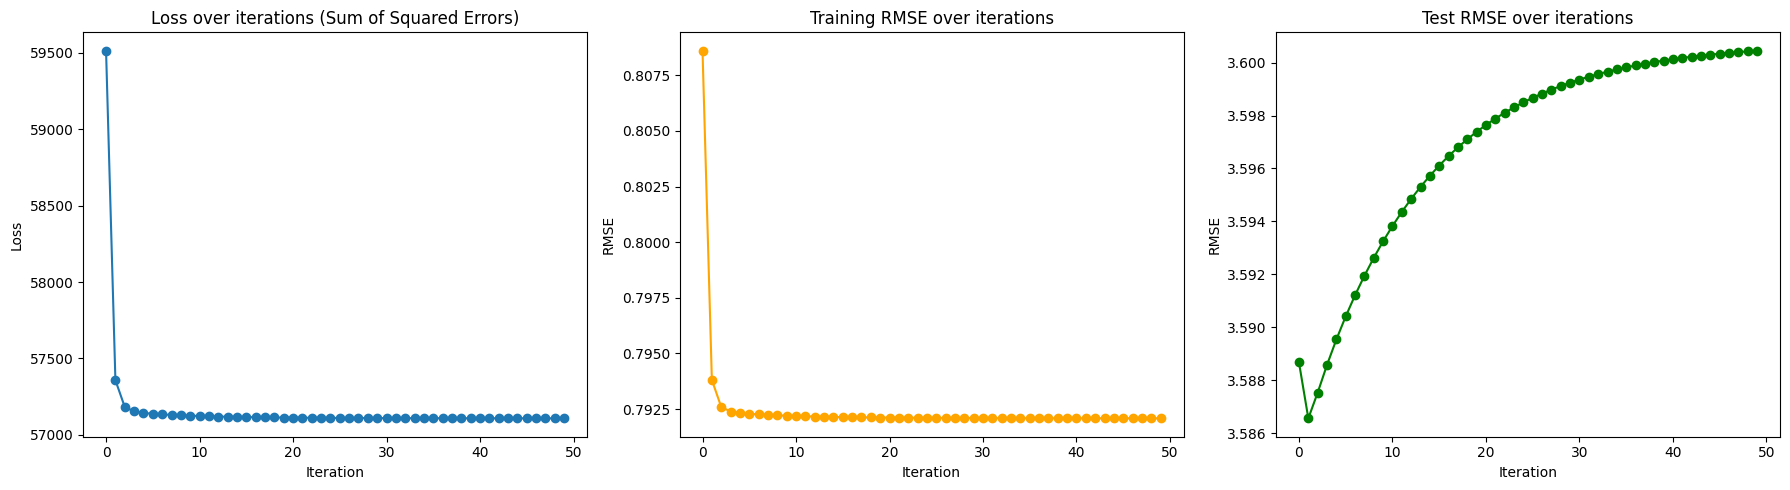

In [ ]:
import matplotlib.pyplot as plt

M = n_users
N = n_movies

lambd = 0.01  # update weight factor
gamma = 0.01  # regularisation term for biases
num_iters = 20

# Initialise user & item biases lists
user_biases = np.zeros((M))
item_biases = np.zeros((N))

# Calculate Global Mean
global_mean = 0
total_ratings = 0
for m in range(M):
    for (movie_idx, r) in data_by_user_train[m]:
        global_mean += r
        total_ratings += 1
global_mean /= total_ratings

# For plotting
loss_history = []
rmse_train_history = []
rmse_test_history  = []

# Start ALS loop
for iter in range(num_iters):
    # Update user biases
    for m in range(M):
        bias = 0 # initialise bias at 0
        count = 0 # to keep track of number of ratings in each user list
        for (movie_idx, r) in data_by_user_train[m]:
            bias += lambd * (r - global_mean - item_biases[movie_idx]) # sum of residuals multiplied by lambda
            # bias += lambd * (r - item_biases[movie_idx]) # sum of residuals multiplied by lambda
            count += 1                                                 # to keep track of how many ratings the user has

        user_biases[m] = bias / (lambd * count + gamma) # gamma regularises the bias for users with few ratings

    # Update item biases
    for n in range(N):
        bias = 0
        count = 0
        for (user_idx, r) in data_by_movie_train[n]:
            bias += lambd * (r - global_mean - user_biases[user_idx])
            # bias += lambd * (r - user_biases[user_idx])
            count += 1

        item_biases[n] = bias / (lambd * count + gamma)

    # Training loss & RMSE
    squared_error = 0
    count = 0
    for m in range(M):
        for movie_idx, r in data_by_user_train[m]:
            # We assume predicted rating = global_mean + user_bias + item_bias
            pred = global_mean + user_biases[m] + item_biases[movie_idx]
            # pred = user_biases[m] + item_biases[movie_idx]
            squared_error += (r - pred) ** 2
            count += 1

    reg_term = lambd * (np.sum(user_biases**2) + np.sum(item_biases**2))

    rmse_train = np.sqrt(squared_error / count)
    total_loss = squared_error + reg_term
    rmse_train_history.append(rmse_train)
    loss_history.append(total_loss)

    # Compute test RMSE
    squared_error_test = 0
    count_test = 0
    for m in range(M):
        for movie_idx, r in data_by_user_test[m]:
            pred = user_biases[m] + item_biases[movie_idx]
            squared_error_test += (r - pred) ** 2
            count_test += 1
    rmse_test = np.sqrt(squared_error_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"Loss = {squared_error:.2f}")

# --- Plot training loss ---
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")

# --- Plot training RMSE ---
plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

# --- Plot test RMSE ---
plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

### Version 2.4

Iteration 1/20: Train RMSE = 1.2755, Test RMSE = 1.3150, Loss = 147379.09
Iteration 2/20: Train RMSE = 0.8663, Test RMSE = 0.9434, Loss = 67989.90
Iteration 3/20: Train RMSE = 0.8143, Test RMSE = 0.9020, Loss = 60071.11
Iteration 4/20: Train RMSE = 0.8047, Test RMSE = 0.8959, Loss = 58663.91
Iteration 5/20: Train RMSE = 0.8018, Test RMSE = 0.8942, Loss = 58232.59
Iteration 6/20: Train RMSE = 0.8005, Test RMSE = 0.8933, Loss = 58050.54
Iteration 7/20: Train RMSE = 0.7998, Test RMSE = 0.8927, Loss = 57954.04
Iteration 8/20: Train RMSE = 0.7994, Test RMSE = 0.8921, Loss = 57891.37
Iteration 9/20: Train RMSE = 0.7991, Test RMSE = 0.8915, Loss = 57843.44
Iteration 10/20: Train RMSE = 0.7988, Test RMSE = 0.8909, Loss = 57802.59
Iteration 11/20: Train RMSE = 0.7985, Test RMSE = 0.8904, Loss = 57765.58
Iteration 12/20: Train RMSE = 0.7983, Test RMSE = 0.8899, Loss = 57731.03
Iteration 13/20: Train RMSE = 0.7981, Test RMSE = 0.8894, Loss = 57698.30
Iteration 14/20: Train RMSE = 0.7979, Test RMS

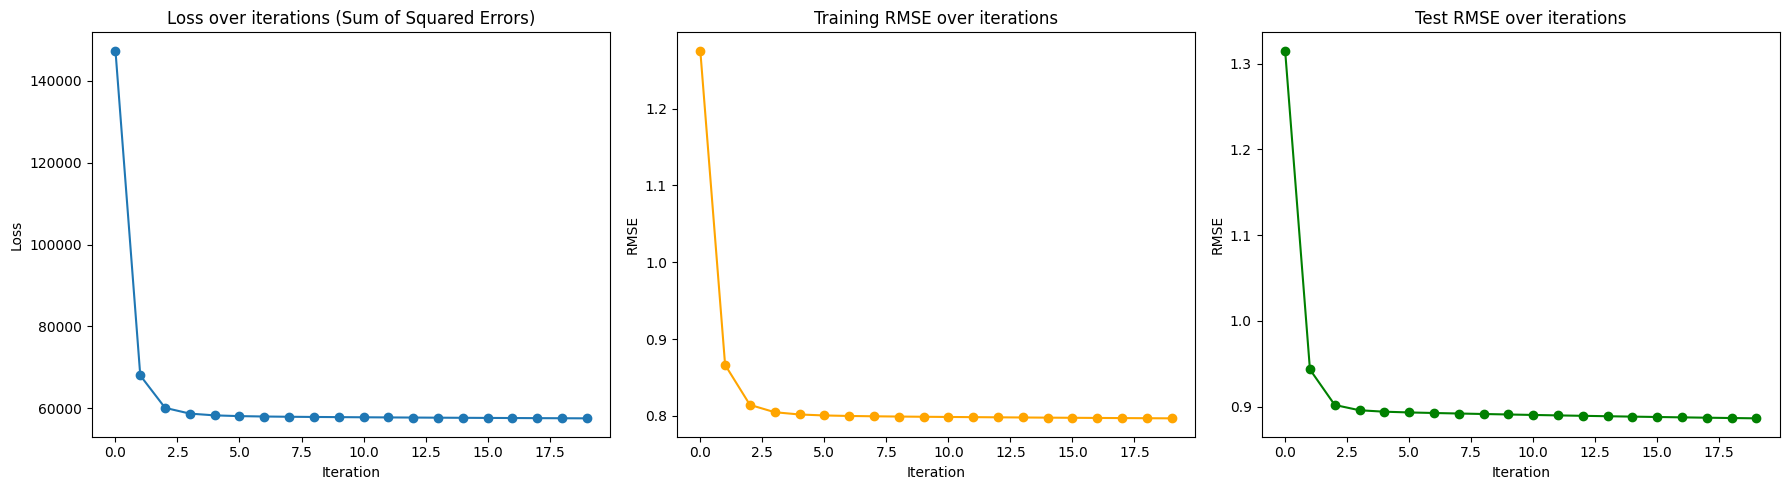

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

M = n_users
N = n_movies

lambd = 0.01   # regularization weight
gamma = 0.01  # smoothing term to avoid division by zero
alpha = 0.5   # learning rate for bias updates
num_iters = 20

user_biases = np.zeros((M))
item_biases = np.zeros((N))

# For plotting
loss_history = []
rmse_history = []
rmse_test_history = []

for iter in range(num_iters):
    # --- Update user biases ---
    for m in range(M):
        bias = 0
        item_counter = 0
        # user_pairs_train[m] contains list of (movie_idx, rating)
        for (movie_idx, r) in user_pairs_train[m]:
            # movie_idx is already an internal index (0-based)
            bias += lambd * (r - item_biases[movie_idx])
            item_counter += 1
        if item_counter > 0:
            bias = bias / (lambd * item_counter + gamma)
            user_biases[m] = (1 - alpha) * user_biases[m] + alpha * bias

    # --- Update item biases ---
    for n in range(N):
        bias = 0
        item_counter = 0
        # movie_pairs_train[n] contains list of (user_idx, rating)
        for (user_idx, r) in movie_pairs_train[n]:
            # user_idx is already an internal index (0-based)
            bias += lambd * (r - user_biases[user_idx])
            item_counter += 1
        if item_counter > 0:
            bias = bias / (lambd * item_counter + gamma)
            item_biases[n] = (1 - alpha) * item_biases[n] + alpha * bias

    # --- Compute training loss & RMSE ---
    squared_error = 0
    count = 0
    for m in range(M):
        for movie_idx, r in user_pairs_train[m]:
            # movie_idx is already an internal index
            pred = user_biases[m] + item_biases[movie_idx]
            squared_error += (r - pred) ** 2
            count += 1

    rmse_train = np.sqrt(squared_error / count)
    rmse_history.append(rmse_train)
    loss_history.append(squared_error)

    # --- Compute test RMSE ---
    squared_error_test = 0
    count_test = 0
    for m in range(M):
        for movie_idx, r in user_pairs_test[m]:
            # movie_idx is already an internal index
            pred = user_biases[m] + item_biases[movie_idx]
            squared_error_test += (r - pred) ** 2
            count_test += 1
    rmse_test = np.sqrt(squared_error_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"Loss = {squared_error:.2f}")

# --- Plot training loss ---
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")

# --- Plot training RMSE ---
plt.subplot(1,3,2)
plt.plot(rmse_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

# --- Plot test RMSE ---
plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

## Part 6: Embeddings Optimisation

### Ulrich's Version

  [Debug] Squared error: 59363.13
  [Debug] Regularization: 10.24
  [Debug] Bias reg: 10.16
  [Debug] Vector reg: 0.08
Iteration 1/20: Train RMSE = 0.8077, Test RMSE = 0.8817, Loss = 59363.13
Iteration 2/20: Train RMSE = 0.7940, Test RMSE = 0.8682, Loss = 57362.56
Iteration 3/20: Train RMSE = 0.7930, Test RMSE = 0.8670, Loss = 57215.12
Iteration 4/20: Train RMSE = 0.7928, Test RMSE = 0.8667, Loss = 57187.55
Iteration 5/20: Train RMSE = 0.7927, Test RMSE = 0.8665, Loss = 57178.00
Iteration 6/20: Train RMSE = 0.7927, Test RMSE = 0.8664, Loss = 57174.46
Iteration 7/20: Train RMSE = 0.7927, Test RMSE = 0.8664, Loss = 57173.98
  [Debug] Squared error: 57175.42
  [Debug] Regularization: 9.47
  [Debug] Bias reg: 9.39
  [Debug] Vector reg: 0.07
Iteration 8/20: Train RMSE = 0.7927, Test RMSE = 0.8664, Loss = 57175.42
Iteration 9/20: Train RMSE = 0.7927, Test RMSE = 0.8664, Loss = 57178.20
Iteration 10/20: Train RMSE = 0.7928, Test RMSE = 0.8664, Loss = 57181.93
Iteration 11/20: Train RMSE = 0.7

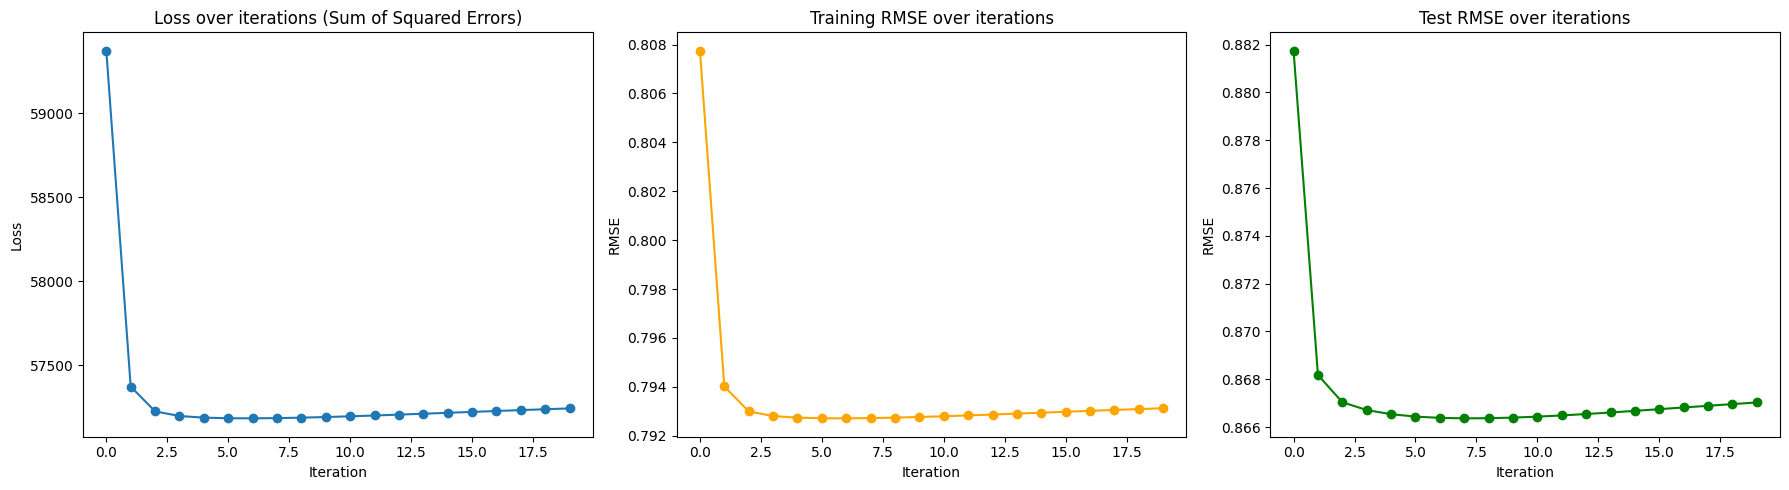


Final Model Parameters:
User embeddings shape: (610, 20)
Item embeddings shape: (9724, 20)
User biases shape: (610,)
Item biases shape: (9724,)


In [ ]:
import matplotlib.pyplot as plt

M = n_users
N = n_movies

K = 20  # number of embedding dimension

lambd = 0.001 # update weight factor
gamma = 0.001 # regularisation term for biases
tau   = 0.1  # regularisation term for user/item vectors

num_iters = 20

# Initialise user & item biases
user_biases = np.zeros((M))
item_biases = np.zeros((N))

# U: user embeddings (M users, K factors)
# V: item embeddings (N items, K factors)
# Initialise with small random values (from normal distribution)
user_vectors = np.random.randn(M, K) * 0.01
item_vectors = np.random.randn(N, K) * 0.01

# For plotting
loss_history = []
rmse_train_history = []
rmse_test_history  = []

# Start ALS loop
for iter in range(num_iters):

    # Update User Parameters (biases & embedding vectors)
    for m in range(M):
        # User Biases
        bias = 0
        count = 0
        for (m_idx, r) in data_by_user_train[m]:
            # Residual now accounts for dot product of embeddings
            residual = r - item_biases[m_idx] - np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            bias += lambd * residual
            count += 1

        if count > 0:
            user_biases[m] = bias / (lambd * count + gamma)

        # User embeddings
        # Solve for user_vector in (A * user_vector = b)
        # Where A is (K x K) and b is (K x 1)

        if count > 0:  # Only update if user has ratings
            A = np.zeros((K, K))   # Accumulator for item vector outer products
            b = np.zeros(K)        # Accumulator for weighted item vectors

            for (m_idx, r) in data_by_user_train[m]:
                # Residual after removing biases
                residual = r - user_biases[m] - item_biases[m_idx]

                # A += lambd * v_n * v_n^T (outer product of item vectors)
                A += lambd * np.outer(item_vectors[m_idx, :], item_vectors[m_idx, :])

                # b += lambd * residual * v_n
                b += lambd * residual * item_vectors[m_idx, :]

            # Add regularization to diagonal: A += gamma_factors * I (identity)
            A += tau * np.eye(K)

            # Solve: A * user_vector[m] = b
            user_vectors[m, :] = np.linalg.solve(A, b)


    # Update Item Parameters (biases and embedding vectors)
    for n in range(N):
        # Item Biases
        bias = 0
        count = 0
        for (u_idx, r) in data_by_movie_train[n]:
            # Residual now accounts for dot product of embeddings
            residual = r - user_biases[u_idx] - np.dot(user_vectors[u_idx, :], item_vectors[n, :])
            bias += lambd * residual
            count += 1

        if count > 0:
            item_biases[n] = bias / (lambd * count + gamma)

        # Item embeddings
        # Solve for item_vector in (A * item_vector = b)
        # Where A is (K x K) and b is (K x 1)

        if count > 0:  # Only update if item has ratings
            A = np.zeros((K, K))
            b = np.zeros(K)

            for (u_idx, r) in data_by_movie_train[n]:
                # Residual after removing biases
                residual = r - user_biases[u_idx] - item_biases[n]

                # A += lambd * u_m * u_m^T (outer product of user vectors)
                A += lambd * np.outer(user_vectors[u_idx, :], user_vectors[u_idx, :])

                # b += lambd * residual * u_m
                b += lambd * residual * user_vectors[u_idx, :]

            # Add regularization to diagonal
            A += tau * np.eye(K)

            # Solve: A * item_vector[n] = b
            item_vectors[n, :] = np.linalg.solve(A, b)


    # Training loss & RMSE
    squared_error = 0
    count = 0
    for m in range(M):
        for m_idx, r in data_by_user_train[m]:
            # Prediction now includes dot product of embeddings
            pred = user_biases[m] + item_biases[m_idx] + np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            squared_error += (r - pred) ** 2
            count += 1

    # Add regularization terms to loss
    regularization = (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2)) +
                      tau * (np.sum(user_vectors**2) + np.sum(item_vectors**2)))

    total_loss = squared_error + regularization

    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)
    loss_history.append(total_loss)  # Changed from squared_error to total_loss

    # Test RMSE
    squared_error_test = 0
    count_test = 0
    for m in range(M):
        for m_idx, r in data_by_user_test[m]:
            # Prediction now includes dot product of embeddings
            pred = user_biases[m] + item_biases[m_idx] + np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            squared_error_test += (r - pred) ** 2
            count_test += 1

    rmse_test = np.sqrt(squared_error_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"Loss = {squared_error:.2f}")

# --- Plot training loss ---
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")

# --- Plot training RMSE ---
plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

# --- Plot test RMSE ---
plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

print(f"\nFinal Model Parameters:")
print(f"User embeddings shape: {user_vectors.shape}")
print(f"Item embeddings shape: {item_vectors.shape}")
print(f"User biases shape: {user_biases.shape}")
print(f"Item biases shape: {item_biases.shape}")

## Part 7: Going Big, Splitting, Training, & Testing

### Load MovieLens 32M dataset

In [ ]:
from google.colab import drive

# Mount your Drive
drive.mount('/content/drive')

# File path
data_path2 = "/content/drive/MyDrive/Data/ML at Scale/ml-32m/" # MovieLens 32M dataset
data_file2 = "ratings.csv"
movies = "movies.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Data/ML at Scale/ml-32m/"

/content/drive/MyDrive/Data/ML at Scale/ml-32m


### Ulrich's Version part 1

In [ ]:
data32m = RatingsData(data_file2)
data32m.load()

In [ ]:
import numpy as np

n_users  = len(data32m.data_by_user)
n_movies = len(data32m.data_by_movie)

# initialising data lists (same # of lists for test/train for consistent indexing)
data_by_user_train = [[] for _ in range(n_users)]
data_by_user_test  = [[] for _ in range(n_users)]
data_by_movie_train = [[] for _ in range(n_movies)]
data_by_movie_test  = [[] for _ in range(n_movies)]

np.random.seed(42)

# data_by_user split
for i in range(n_users): # loop over all users
    tuples = data32m.data_by_user[i]
    for movie_idx, rating in tuples: # loop over all tuples
        if np.random.rand() < 0.95:
            data_by_user_train[i].append((movie_idx, rating)) # add to train
        else:
            data_by_user_test[i].append((movie_idx, rating)) # add to test

# data_by_movie split
for user_idx in range(n_users): # loop over all users
    # train
    for movie_idx, rating in data_by_user_train[user_idx]: # loop over all tuples
        data_by_movie_train[movie_idx].append((user_idx, rating)) # add in correct movie_idx and replace (movie_id with user_id)

    # test
    for movie_idx, rating in data_by_user_test[user_idx]:
        data_by_movie_test[movie_idx].append((user_idx, rating))

In [ ]:
non_empty_users_train = sum(1 for u in data_by_user_train if len(u) > 0)
non_empty_users_test  = sum(1 for u in data_by_user_test if len(u) > 0)

print(f"number of items in users train and test sets: {len(data_by_user_train)} , {len(data_by_user_test)}")
print(f"Number of users with ratings in train and test sets: {non_empty_users_train}, {non_empty_users_test}")

print()

non_empty_movies_train = sum(1 for u in data_by_movie_train if len(u) > 0)
non_empty_movies_test  = sum(1 for u in data_by_movie_test if len(u) > 0)

print(f"number of items in movies train and test sets: {len(data_by_movie_train)}, {len(data_by_movie_test)}")
print(f"Number of movies with ratings in train and test sets: {non_empty_movies_train}, {non_empty_movies_test}")

number of items in users train and test sets: 200948 , 200948
Number of users with ratings in train and test sets: 200948, 197206

number of items in movies train and test sets: 84432, 84432
Number of movies with ratings in train and test sets: 82410, 42714


Iteration 1/10: Train RMSE = 0.8607, Test RMSE = 0.8700, Loss = 21336920.78
Iteration 2/10: Train RMSE = 0.7982, Test RMSE = 0.8226, Loss = 18349059.12
Iteration 3/10: Train RMSE = 0.7394, Test RMSE = 0.7948, Loss = 15745156.68
Iteration 4/10: Train RMSE = 0.7258, Test RMSE = 0.7847, Loss = 15174673.65
Iteration 5/10: Train RMSE = 0.7204, Test RMSE = 0.7798, Loss = 14949294.19
Iteration 6/10: Train RMSE = 0.7177, Test RMSE = 0.7771, Loss = 14834285.22
Iteration 7/10: Train RMSE = 0.7161, Test RMSE = 0.7755, Loss = 14768305.59
Iteration 8/10: Train RMSE = 0.7151, Test RMSE = 0.7745, Loss = 14727351.44
Iteration 9/10: Train RMSE = 0.7144, Test RMSE = 0.7738, Loss = 14700269.41
Iteration 10/10: Train RMSE = 0.7139, Test RMSE = 0.7734, Loss = 14681419.86


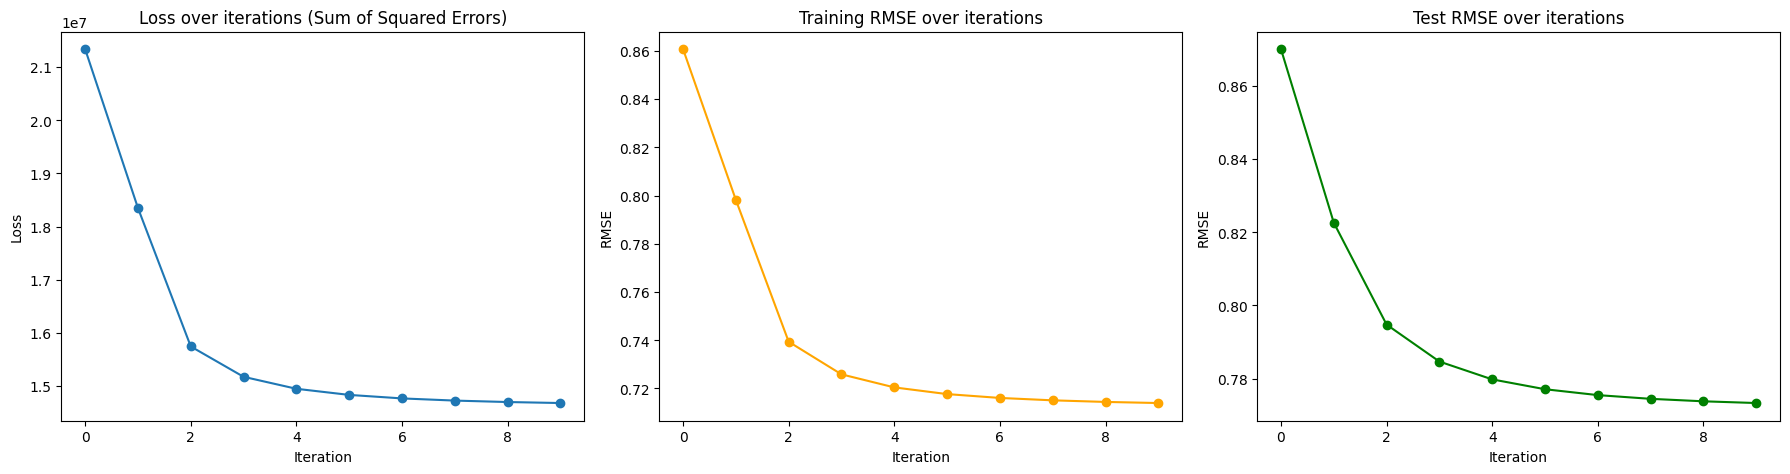


Final Model Parameters:
User embeddings shape: (200948, 20)
Item embeddings shape: (84432, 20)
User biases shape: (200948,)
Item biases shape: (84432,)


In [ ]:
import matplotlib.pyplot as plt

M = n_users
N = n_movies

K = 20  # number of embedding dimension

lambd = 0.001 # update weight factor
gamma = 0.001 # regularisation term for biases
tau   = 0.05  # regularisation term for user/item vectors

num_iters = 10

# Initialise user & item biases
user_biases = np.zeros((M))
item_biases = np.zeros((N))

# U: user embeddings (M users, K factors)
# V: item embeddings (N items, K factors)
# Initialise with small random values (from normal distribution)
user_vectors = np.random.randn(M, K) * 0.01
item_vectors = np.random.randn(N, K) * 0.01

# For plotting
loss_history = []
rmse_train_history = []
rmse_test_history  = []

# Start ALS loop
for iter in range(num_iters):

    # Update User Parameters (biases & embedding vectors)
    for m in range(M):
        # User Biases
        bias = 0
        count = 0
        for (m_idx, r) in data_by_user_train[m]:
            # Residual now accounts for dot product of embeddings
            residual = r - item_biases[m_idx] - np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            bias += lambd * residual
            count += 1

        if count > 0:
            user_biases[m] = bias / (lambd * count + gamma)

        # User embeddings
        # Solve for user_vector in (A * user_vector = b)
        # Where A is (K x K) and b is (K x 1)

        if count > 0:  # Only update if user has ratings
            A = np.zeros((K, K))   # Accumulator for item vector outer products
            b = np.zeros(K)        # Accumulator for weighted item vectors

            for (m_idx, r) in data_by_user_train[m]:
                # Residual after removing biases
                residual = r - user_biases[m] - item_biases[m_idx]

                # A += lambd * v_n * v_n^T (outer product of item vectors)
                A += lambd * np.outer(item_vectors[m_idx, :], item_vectors[m_idx, :])

                # b += lambd * residual * v_n
                b += lambd * residual * item_vectors[m_idx, :]

            # Add regularization to diagonal: A += gamma_factors * I (identity)
            A += tau * np.eye(K)

            # Solve: A * user_vector[m] = b
            user_vectors[m, :] = np.linalg.solve(A, b)


    # Update Item Parameters (biases and embedding vectors)
    for n in range(N):
        # Item Biases
        bias = 0
        count = 0
        for (u_idx, r) in data_by_movie_train[n]:
            # Residual now accounts for dot product of embeddings
            residual = r - user_biases[u_idx] - np.dot(user_vectors[u_idx, :], item_vectors[n, :])
            bias += lambd * residual
            count += 1

        if count > 0:
            item_biases[n] = bias / (lambd * count + gamma)

        # Item embeddings
        # Solve for item_vector in (A * item_vector = b)
        # Where A is (K x K) and b is (K x 1)

        if count > 0:  # Only update if item has ratings
            A = np.zeros((K, K))
            b = np.zeros(K)

            for (u_idx, r) in data_by_movie_train[n]:
                # Residual after removing biases
                residual = r - user_biases[u_idx] - item_biases[n]

                # A += lambd * u_m * u_m^T (outer product of user vectors)
                A += lambd * np.outer(user_vectors[u_idx, :], user_vectors[u_idx, :])

                # b += lambd * residual * u_m
                b += lambd * residual * user_vectors[u_idx, :]

            # Add regularization to diagonal
            A += tau * np.eye(K)

            # Solve: A * item_vector[n] = b
            item_vectors[n, :] = np.linalg.solve(A, b)


    # Training loss & RMSE
    squared_error = 0
    count = 0
    for m in range(M):
        for m_idx, r in data_by_user_train[m]:
            # Prediction now includes dot product of embeddings
            pred = user_biases[m] + item_biases[m_idx] + np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            squared_error += (r - pred) ** 2
            count += 1

    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)
    loss_history.append(squared_error)

    # Test RMSE
    squared_error_test = 0
    count_test = 0
    for m in range(M):
        for m_idx, r in data_by_user_test[m]:
            # Prediction now includes dot product of embeddings
            pred = user_biases[m] + item_biases[m_idx] + np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            squared_error_test += (r - pred) ** 2
            count_test += 1

    rmse_test = np.sqrt(squared_error_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"Loss = {squared_error:.2f}")

# --- Plot training loss ---
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")

# --- Plot training RMSE ---
plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

# --- Plot test RMSE ---
plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

print(f"\nFinal Model Parameters:")
print(f"User embeddings shape: {user_vectors.shape}")
print(f"Item embeddings shape: {item_vectors.shape}")
print(f"User biases shape: {user_biases.shape}")
print(f"Item biases shape: {item_biases.shape}")

### Ulrich's Version part 2

In [ ]:
import numpy as np

# Load all model parameters
model_data = np.load('movie_recommender_model.npz')

user_vectors = model_data['user_vectors']
item_vectors = model_data['item_vectors']
user_biases = model_data['user_biases']
item_biases = model_data['item_biases']
K = int(model_data['K'])
M = int(model_data['M'])
N = int(model_data['N'])

print("Model loaded successfully!")
print(f"User embeddings shape: {user_vectors.shape}")
print(f"Item embeddings shape: {item_vectors.shape}")
print(f"User biases shape: {user_biases.shape}")
print(f"Item biases shape: {item_biases.shape}")

Model loaded successfully!
User embeddings shape: (200948, 20)
Item embeddings shape: (84432, 20)
User biases shape: (200948,)
Item biases shape: (84432,)


In [ ]:
def create_dummy_user_and_recommend(dummy_ratings, user_vectors, item_vectors,
                                     user_biases, item_biases, data32m,
                                     lambd=0.001, tau=0.05, gamma=0.001,
                                     top_k=10, min_ratings=100, bias_weight=0.05):
    """
    Create a dummy user with given ratings and generate recommendations.

    Args:
        dummy_ratings: List of (movie_id, rating) tuples (using actual movie IDs, not indices)
        user_vectors: Trained user embeddings (M x K)
        item_vectors: Trained item embeddings (N x K)
        user_biases: Trained user biases (M,)
        item_biases: Trained item biases (N,)
        data32m: RatingsData object for ID-to-index mappings
        lambd: Update weight factor
        tau: Regularization for embeddings
        gamma: Regularization for biases
        top_k: Number of recommendations to return
        min_ratings: Minimum number of ratings a movie must have to be recommended
        bias_weight: How much to weight the item bias (0.05 = 5%)

    Returns:
        top_movie_ids: List of top K recommended movie IDs
        top_scores: List of corresponding scores
        dummy_user_vector: The computed dummy user embedding
        dummy_user_bias: The computed dummy user bias
    """

    K = user_vectors.shape[1]  # Number of latent dimensions

    # Convert movie IDs to indexes
    dummy_movie_indices = []
    dummy_movie_ratings = []
    for movie_id, rating in dummy_ratings:
        if movie_id in data32m.movie_id_to_idx:
            m_idx = data32m.movie_id_to_idx[movie_id]
            dummy_movie_indices.append(m_idx)
            dummy_movie_ratings.append(rating)
        else:
            print(f"Warning: Movie ID {movie_id} not found in dataset")

    n_ratings = len(dummy_movie_indices)
    if n_ratings == 0:
        raise ValueError("No valid movie ratings provided")

    print(f"Creating dummy user with {n_ratings} ratings...")

    # STEP 1: Compute Dummy User Bias #
    bias_sum = 0.0
    for m_idx, rating in zip(dummy_movie_indices, dummy_movie_ratings):
        # Residual = rating - item_bias (no user embedding yet)
        residual = rating - item_biases[m_idx]
        bias_sum += lambd * residual

    dummy_user_bias = bias_sum / (lambd * n_ratings + gamma)

    # STEP 2: Compute Dummy User Embedding #
    A = tau * np.eye(K)  # Start with regularization
    b = np.zeros(K)

    for m_idx, rating in zip(dummy_movie_indices, dummy_movie_ratings):
        # Residual after accounting for biases
        residual = rating - dummy_user_bias - item_biases[m_idx]

        v = item_vectors[m_idx, :]  # Item embedding
        A += lambd * np.outer(v, v)
        b += lambd * residual * v

    # Solve: A * dummy_user_vector = b
    dummy_user_vector = np.linalg.solve(A, b)

    print(f"Dummy user bias: {dummy_user_bias:.4f}")
    print(f"Dummy user embedding norm: {np.linalg.norm(dummy_user_vector):.4f}")

    # STEP 3: Score All Movies #
    print("\nScoring all movies...")
    N = len(item_biases)
    scores = np.zeros(N)

    # Vectorized scoring
    scores = (np.dot(item_vectors, dummy_user_vector) +  # Personalization
              bias_weight * item_biases)                  # Popularity (downweighted)

    # STEP 4: Filter and Rank #
    print(f"Filtering movies with < {min_ratings} ratings...")

    # Count ratings per movie in training data
    movie_rating_counts = np.array([len(data32m.data_by_movie[i])
                                    for i in range(N)])

    # Mask out movies with too few ratings
    valid_mask = movie_rating_counts >= min_ratings
    scores[~valid_mask] = -np.inf  # Set invalid movies to very low score

    # Also mask out movies the dummy user already rated
    for m_idx in dummy_movie_indices:
        scores[m_idx] = -np.inf

    # Get top K recommendations
    top_indices = np.argsort(scores)[::-1][:top_k]
    top_scores = scores[top_indices]

    # Convert indices back to movie IDs
    top_movie_ids = [data32m.idx_to_movie_id[idx] for idx in top_indices]

    return top_movie_ids, top_scores, dummy_user_vector, dummy_user_bias

In [ ]:
def display_recommendations(top_movie_ids, top_scores, movies_df=None):
    """
    Display recommendations in a nice format.

    Args:
        top_movie_ids: List of recommended movie IDs
        top_scores: List of corresponding scores
        movies_df: Optional pandas DataFrame with movie metadata
    """
    print("TOP RECOMMENDATIONS")

    for i, (movie_id, score) in enumerate(zip(top_movie_ids, top_scores), 1):
        print(f"\n{i}. Movie ID: {movie_id} | Score: {score:.4f}")

        if movies_df is not None:
            # Look up movie details
            movie_info = movies_df[movies_df['movieId'] == movie_id]
            if not movie_info.empty:
                title = movie_info['title'].values[0]
                genres = movie_info['genres'].values[0]
                print(f"   Title: {title}")
                print(f"   Genres: {genres}")
            else:
                print(f"   (Movie details not found)")

In [ ]:
import pandas as pd

#Load file into pandas dataframe
df = pd.read_csv(movies)

In [ ]:
top_movie_ids, top_scores, dummy_user_vector, dummy_user_bias = create_dummy_user_and_recommend([(296, 5)], user_vectors,
                                                                     item_vectors, user_biases, item_biases, data32m,
                                                                     lambd=0.001, tau=0.05, gamma=0.001,
                                                                     top_k=10, min_ratings=100, bias_weight=0.05)

Creating dummy user with 1 ratings...
Dummy user bias: 2.0211
Dummy user embedding norm: 0.1371

Scoring all movies...
Filtering movies with < 100 ratings...


In [ ]:
display_recommendations(top_movie_ids, top_scores, df)

TOP RECOMMENDATIONS

1. Movie ID: 1089 | Score: 0.7785
   Title: Reservoir Dogs (1992)
   Genres: Crime|Mystery|Thriller

2. Movie ID: 6874 | Score: 0.7673
   Title: Kill Bill: Vol. 1 (2003)
   Genres: Action|Crime|Thriller

3. Movie ID: 7438 | Score: 0.7082
   Title: Kill Bill: Vol. 2 (2004)
   Genres: Action|Drama|Thriller

4. Movie ID: 608 | Score: 0.6886
   Title: Fargo (1996)
   Genres: Comedy|Crime|Drama|Thriller

5. Movie ID: 858 | Score: 0.6677
   Title: Godfather, The (1972)
   Genres: Crime|Drama

6. Movie ID: 2959 | Score: 0.6137
   Title: Fight Club (1999)
   Genres: Action|Crime|Drama|Thriller

7. Movie ID: 1221 | Score: 0.5959
   Title: Godfather: Part II, The (1974)
   Genres: Crime|Drama

8. Movie ID: 778 | Score: 0.5635
   Title: Trainspotting (1996)
   Genres: Comedy|Crime|Drama

9. Movie ID: 1732 | Score: 0.5483
   Title: Big Lebowski, The (1998)
   Genres: Comedy|Crime

10. Movie ID: 288 | Score: 0.5424
   Title: Natural Born Killers (1994)
   Genres: Action|Crime|T

### Version 2.3

In [ ]:
data32m = RatingsCSR2(data_file2)
data32m.load()

Pass 1: dimensions and count...
Users: 200948, Movies: 292757, Ratings: 32000204
Pass 2: counting users/movies...
Pass 3: filling and sorting arrays...
Done!
Memory: User CSR uses 2 arrays, Movie CSR uses 2 arrays (4 total), No dictionary necessary


In [ ]:
import numpy as np

def train_test_split_csr(data, test_ratio=0.02, seed=42):
    """
    Split data and returns two RatingsCSR2-like objects (train and test).
    """
    np.random.seed(seed)

    n_users  = data.n_users
    n_movies = data.n_movies
    total_ratings = len(data.user_pairs)

    print(f"Creating train/test split ({test_ratio*100:.0f}% test)...")
    print(f"Users: {n_users:,}, Movies: {n_movies:,}, Ratings: {total_ratings:,}")

    # Generate random mask for all ratings (train/test split)
    print("\nStep 1: Generating random split mask...")
    is_train = np.random.rand(total_ratings) > test_ratio

    n_train = np.sum(is_train)
    n_test  = total_ratings - n_train
    print(f"  Train: {n_train:,} ({100*n_train/total_ratings:.1f}%)")
    print(f"  Test:  {n_test:,} ({100*n_test/total_ratings:.1f}%)")

    # Split user_pairs directly using boolean mask
    print("\nStep 2: Splitting user CSR...")
    dtype = data.user_pairs.dtype

    train_user_pairs = data.user_pairs[is_train].copy()
    test_user_pairs = data.user_pairs[~is_train].copy()

    # Rebuild user_indptr for train and test
    print("Step 3: Rebuilding user index pointers...")

    train_user_indptr = np.zeros(n_users + 1, dtype=np.int32)
    test_user_indptr  = np.zeros(n_users + 1, dtype=np.int32)

    # Count ratings per user in train/test
    train_pos = 0
    test_pos  = 0

    for user_idx in range(n_users):
        start = data.user_indptr[user_idx]
        end = data.user_indptr[user_idx + 1]

        # Count how many of this user's ratings are in train/test
        user_is_train = is_train[start:end]
        n_train_user = np.sum(user_is_train)
        n_test_user = (end - start) - n_train_user

        # Update positions
        train_user_indptr[user_idx + 1] = train_user_indptr[user_idx] + n_train_user
        test_user_indptr[user_idx + 1]  = test_user_indptr[user_idx] + n_test_user

    # Rebuild movie CSR from scratch based on user CSR
    print("Step 4: Building movie CSR for train...")
    train_movie_pairs, train_movie_indptr = _build_movie_csr(
        train_user_pairs, train_user_indptr, n_users, n_movies, dtype
    )

    print("Step 5: Building movie CSR for test...")
    test_movie_pairs, test_movie_indptr = _build_movie_csr(
        test_user_pairs, test_user_indptr, n_users, n_movies, dtype
    )

    # Sort both CSRs
    print("Step 6: Sorting CSR indices...")
    _sort_csr(train_user_pairs, train_user_indptr, n_users)
    _sort_csr(train_movie_pairs, train_movie_indptr, n_movies)
    _sort_csr(test_user_pairs, test_user_indptr, n_users)
    _sort_csr(test_movie_pairs, test_movie_indptr, n_movies)

    # STEP 7: Create output objects
    print("\nStep 7: Creating output objects...")

    class SplitData:
        """Container for split CSR data."""
        def __init__(self, user_pairs, user_indptr, movie_pairs, movie_indptr, n_users, n_movies):
            self.user_pairs = user_pairs
            self.user_indptr = user_indptr
            self.movie_pairs = movie_pairs
            self.movie_indptr = movie_indptr
            self.n_users = n_users
            self.n_movies = n_movies

        def get_user_ratings(self, user_id):
            """Get ratings for user (1-indexed)."""
            start, end = self.user_indptr[user_id - 1], self.user_indptr[user_id]
            pairs = self.user_pairs[start:end]
            return [(int(p['idx'] + 1), float(p['rating'])) for p in pairs], end - start

        def get_movie_ratings(self, movie_id):
            """Get ratings for movie (1-indexed)."""
            start, end = self.movie_indptr[movie_id - 1], self.movie_indptr[movie_id]
            pairs = self.movie_pairs[start:end]
            return [(int(p['idx'] + 1), float(p['rating'])) for p in pairs], end - start

    train_data = SplitData(train_user_pairs, train_user_indptr,
                          train_movie_pairs, train_movie_indptr,
                          n_users, n_movies)

    test_data = SplitData(test_user_pairs, test_user_indptr,
                         test_movie_pairs, test_movie_indptr,
                         n_users, n_movies)

    print("✓ Split complete!\n")
    return train_data, test_data


def _build_movie_csr(user_pairs, user_indptr, n_users, n_movies, dtype):
    """
    Build movie CSR from user CSR.
    This is unavoidable since we need to transpose the structure.
    """
    n_ratings = len(user_pairs)

    # Count ratings per movie
    movie_counts = np.zeros(n_movies, dtype=np.int32)
    for i in range(n_ratings):
        movie_idx = user_pairs[i]['idx']
        movie_counts[movie_idx] += 1

    # Build movie indptr
    movie_indptr = np.zeros(n_movies + 1, dtype=np.int32)
    movie_indptr[1:] = np.cumsum(movie_counts)

    # Allocate movie pairs
    movie_pairs = np.zeros(n_ratings, dtype=dtype)

    # Fill movie pairs
    movie_pos = movie_indptr[:-1].copy()

    for user_idx in range(n_users):
        start = user_indptr[user_idx]
        end = user_indptr[user_idx + 1]

        for pos in range(start, end):
            movie_idx = user_pairs[pos]['idx']
            rating = user_pairs[pos]['rating']

            # Add (user_idx, rating) to movie's list
            movie_pairs[movie_pos[movie_idx]] = (user_idx, rating)
            movie_pos[movie_idx] += 1

    return movie_pairs, movie_indptr


def _sort_csr(pairs, indptr, n):
    """Sort CSR pairs by index."""
    for i in range(n):
        start, end = indptr[i], indptr[i + 1]
        if end - start > 1:
            order = np.argsort(pairs[start:end]['idx'], kind='stable')
            pairs[start:end] = pairs[start:end][order]

In [ ]:
# Split (returns two CSR objects)
train_data, test_data = train_test_split_csr(data32m, test_ratio=0.02, seed=42)

Creating train/test split (2% test)...
Users: 200,948, Movies: 292,757, Ratings: 32,000,204

Step 1: Generating random split mask...
  Train: 31,359,691 (98.0%)
  Test:  640,513 (2.0%)

Step 2: Splitting user CSR...
Step 3: Rebuilding user index pointers...
Step 4: Building movie CSR for train...
Step 5: Building movie CSR for test...
Step 6: Sorting CSR indices...

Step 7: Creating output objects...
✓ Split complete!



### User Embedings and Biases Optimisation Version 2.3

In [ ]:
### Not adjusted for csr yet ###

import numpy as np
import matplotlib.pyplot as plt

M = n_users
N = n_movies

K = 20  # number of embedding dimension

lambd = 0.001 # update weight factor
gamma = 0.001 # regularisation term for biases
tau   = 0.05  # regularisation term for user/item vectors

num_iters = 8

# Initialise user & item biases
user_biases = np.zeros((M))
item_biases = np.zeros((N))

# U: user embeddings (M users, K factors)
# V: item embeddings (N items, K factors)
# Initialise with small random values (from normal distribution)
user_vectors = np.random.randn(M, K) * 0.01
item_vectors = np.random.randn(N, K) * 0.01

# For plotting
loss_history = []
rmse_train_history = []
rmse_test_history  = []

# Start ALS loop
for iter in range(num_iters):

    # Update User Parameters (biases & embedding vectors)
    for m in range(M):
        # User Biases
        bias = 0
        count = 0
        for (movie_id, r) in data_by_user_train[m]:
            m_idx = data100k.movie_id_to_idx[movie_id]
            # Residual now accounts for dot product of embeddings
            residual = r - item_biases[m_idx] - np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            bias += lambd * residual
            count += 1

        if count > 0:
            user_biases[m] = bias / (lambd * count + gamma)

        # User embeddings
        # Solve for user_vector in (A * user_vector = b)
        # Where A is (K x K) and b is (K x 1)

        if count > 0:  # Only update if user has ratings
            A = np.zeros((K, K))   # Accumulator for item vector outer products
            b = np.zeros(K)        # Accumulator for weighted item vectors

            for (movie_id, r) in data_by_user_train[m]:
                m_idx = data100k.movie_id_to_idx[movie_id]
                # Residual after removing biases
                residual = r - user_biases[m] - item_biases[m_idx]

                # A += lambd * v_n * v_n^T (outer product of item vectors)
                A += lambd * np.outer(item_vectors[m_idx, :], item_vectors[m_idx, :])

                # b += lambd * residual * v_n
                b += lambd * residual * item_vectors[m_idx, :]

            # Add regularization to diagonal: A += gamma_factors * I (identity)
            A += tau * np.eye(K)

            # Solve: A * user_vector[m] = b
            user_vectors[m, :] = np.linalg.solve(A, b)


    # Update Item Parameters (biases and embedding vectors)
    for n in range(N):
        # Item Biases
        bias = 0
        count = 0
        for (user_id, r) in data_by_movie_train[n]:
            u_idx = data100k.user_id_to_idx[user_id]
            # Residual now accounts for dot product of embeddings
            residual = r - user_biases[u_idx] - np.dot(user_vectors[u_idx, :], item_vectors[n, :])
            bias += lambd * residual
            count += 1

        if count > 0:
            item_biases[n] = bias / (lambd * count + gamma)

        # Item embeddings
        # Solve for item_vector in (A * item_vector = b)
        # Where A is (K x K) and b is (K x 1)

        if count > 0:  # Only update if item has ratings
            A = np.zeros((K, K))
            b = np.zeros(K)

            for (user_id, r) in data_by_movie_train[n]:
                u_idx = data100k.user_id_to_idx[user_id]
                # Residual after removing biases
                residual = r - user_biases[u_idx] - item_biases[n]

                # A += lambd * u_m * u_m^T (outer product of user vectors)
                A += lambd * np.outer(user_vectors[u_idx, :], user_vectors[u_idx, :])

                # b += lambd * residual * u_m
                b += lambd * residual * user_vectors[u_idx, :]

            # Add regularization to diagonal
            A += tau * np.eye(K)

            # Solve: A * item_vector[n] = b
            item_vectors[n, :] = np.linalg.solve(A, b)


    # Training loss & RMSE
    squared_error = 0
    count = 0
    for m in range(M):
        for movie_id, r in data_by_user_train[m]:
            m_idx = data100k.movie_id_to_idx[movie_id]
            # Prediction now includes dot product of embeddings
            pred = user_biases[m] + item_biases[m_idx] + np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            squared_error += (r - pred) ** 2
            count += 1

    rmse_train = np.sqrt(squared_error / count)
    rmse_train_history.append(rmse_train)
    loss_history.append(squared_error)

    # Test RMSE
    squared_error_test = 0
    count_test = 0
    for m in range(M):
        for movie_id, r in data_by_user_test[m]:
            m_idx = data100k.movie_id_to_idx[movie_id]
            # Prediction now includes dot product of embeddings
            pred = user_biases[m] + item_biases[m_idx] + np.dot(user_vectors[m, :], item_vectors[m_idx, :])
            squared_error_test += (r - pred) ** 2
            count_test += 1

    rmse_test = np.sqrt(squared_error_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iteration {iter+1}/{num_iters}: "
          f"Train RMSE = {rmse_train:.4f}, Test RMSE = {rmse_test:.4f}, "
          f"Loss = {squared_error:.2f}")

# --- Plot training loss ---
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")

# --- Plot training RMSE ---
plt.subplot(1,3,2)
plt.plot(rmse_train_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

# --- Plot test RMSE ---
plt.subplot(1,3,3)
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()

print(f"\nFinal Model Parameters:")
print(f"User embeddings shape: {user_vectors.shape}")
print(f"Item embeddings shape: {item_vectors.shape}")
print(f"User biases shape: {user_biases.shape}")
print(f"Item biases shape: {item_biases.shape}")

NameError: name 'n_users' is not defined

## Part 8: Joint Density Plot

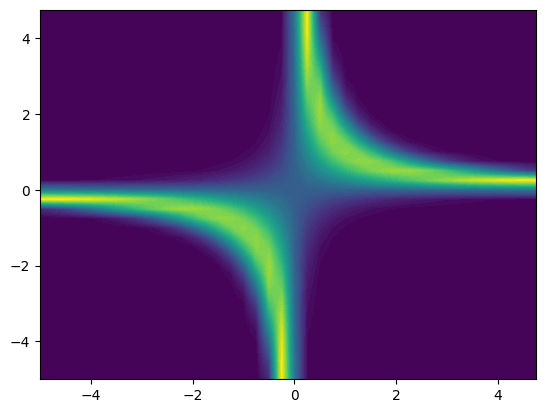

In [ ]:
u = np.arange(-5, 5, 0.25)
v = np.arange(-5, 5, 0.25)
U, V = np.meshgrid(u, v)

tau   = 0.01
lambd = 2
r     = 1

P = np.exp(-0.5 * (lambd * (r - U*V)**2) + (tau * (U**2 + V**2)))

surf = plt.contourf(U, V, P, levels=50, cmap='viridis')